In [22]:
%pip install torch torchvision numpy matplotlib pandas pillow


Note: you may need to restart the kernel to use updated packages.


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

emotion_to_number = {
    "neutral": 0,
    "happy": 1,
    "sad": 2,
    "anger": 3,
    "surprise": 4,
    "disgust": 5,
    "fear": 6
}

In [24]:
class EmotionDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.labels_df.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.labels_df.iloc[idx, 1]
        label = emotion_to_number[label]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

transform = transforms.Compose([
    transforms.Resize((48, 48)),  
    transforms.ToTensor(),        
    transforms.Normalize((0.5,), (0.5,)) 
])


img_dir = "./project_data/training_set/"
csv_file = "./project_data/training_set.csv"
dataset = EmotionDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [25]:
batch_size = 64
learning_rate = 0.001
num_epochs = 10

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((700, 700)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [26]:
class CNNEmotionClassifier(nn.Module):
    def __init__(self):
        super(CNNEmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 6 * 6, 512)  
        self.fc2 = nn.Linear(512, 7)  
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 6 * 6)  
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = CNNEmotionClassifier()

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(dataloader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if (i+1) % 100 == 0:    
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

print('Finished Training')

Epoch [1/10], Loss: 1.9460
Epoch [2/10], Loss: 1.9421
Epoch [3/10], Loss: 1.9378
Epoch [4/10], Loss: 1.9291
Epoch [5/10], Loss: 1.8543
Epoch [6/10], Loss: 1.5661
Epoch [7/10], Loss: 1.3413
Epoch [8/10], Loss: 1.2235
Epoch [9/10], Loss: 1.0782
Epoch [10/10], Loss: 0.9269
Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77254903..0.7882353].


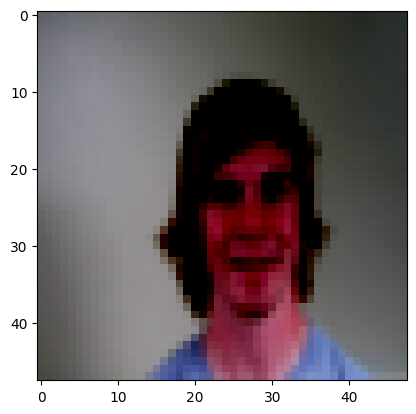

tensor(1)


In [28]:
plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))
plt.show()
print(labels[0])

In [29]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the validation set: {100 * correct / total}%')

Accuracy of the model on the validation set: 64.89252814738997%
